# Download and inspect pixelgen data
ran on pixel_env

In [5]:
from pixelator import read

In [6]:
pixel_dir = "/home/labs/amit/floriani/Lab/PROJECTS/Pixelgen/data/raw/PBMC_pilot_data/"
# baseurl = "https://pixelgen-technologies-datasets.s3.eu-north-1.amazonaws.com/mpx-datasets/pixelator/0.18.x/technote-v1-vs-v2-immunology-II"
# baseurl = 'https://pixelgen-technologies-datasets.s3.eu-north-1.amazonaws.com/mpx-datasets/pixelator/0.18.x/1k-human-pbmcs-v1.0-immunology-I'

# !curl -L -C - --create-dirs -o {pixel_dir}Sample01_human_pbmcs_unstimulated.layout.dataset.pxl "{baseurl}/Sample01_human_pbmcs_unstimulated.layout.dataset.pxl"
# !curl -L -O -C - --create-dirs -o {pixel_dir}Sample02_human_pbmcs_unstimulated.layout.dataset.pxl "{baseurl}/Sample02_human_pbmcs_unstimulated.layout.dataset.pxl"

In [7]:
# read data
pg_data_r1 = read(f"{pixel_dir}Sample05_V2_PBMC_r1.layout.dataset.pxl")
pg_data_r2 = read(f"{pixel_dir}Sample06_V2_PBMC_r2.layout.dataset.pxl")

In [8]:
pg_data_r1.adata

/home/labs/amit/floriani/mambaforge/envs/pixel_env/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_elem from `anndata.experimental` is deprecated. Import anndata.io.read_elem instead.
  warnings.warn(msg, FutureWarning)


AnnData object with n_obs × n_vars = 1125 × 84
    obs: 'pixels', 'a_pixels', 'b_pixels', 'antibodies', 'molecules', 'reads', 'mean_reads_per_molecule', 'median_reads_per_molecule', 'mean_b_pixels_per_a_pixel', 'median_b_pixels_per_a_pixel', 'mean_a_pixels_per_b_pixel', 'median_a_pixels_per_b_pixel', 'a_pixel_b_pixel_ratio', 'mean_molecules_per_a_pixel', 'median_molecules_per_a_pixel', 'leiden', 'tau_type', 'tau'
    var: 'antibody_count', 'components', 'antibody_pct', 'nuclear', 'control'
    uns: 'neighbors', 'tau_thresholds', 'umap', 'version'
    obsm: 'X_umap', 'clr', 'log1p'
    obsp: 'connectivities', 'distances'

In [9]:
# merge datasets
from pixelator import simple_aggregate
pd_data = simple_aggregate(sample_names = ['Sample5', 'Sample6'], datasets = [pg_data_r1, pg_data_r2])
pd_data

/home/labs/amit/floriani/mambaforge/envs/pixel_env/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_elem from `anndata.experimental` is deprecated. Import anndata.io.read_elem instead.
  warnings.warn(msg, FutureWarning)


Pixel dataset contains:
  AnnData with 2265 obs and 84 vars
  Edge list with 52400382 edges
  Polarization scores with 169431 elements
  Colocalization scores with 6277762 elements
  Contains precomputed layouts
  Metadata:
    samples: {'Sample5': {'version': '0.18.0', 'sample': 'Sample05_V2_PBMC_r1', 'analysis': {'params': {'polarization': {'polarization': {'transformation': 'log1p', 'permutations': 50, 'min_marker_count': 5, 'random_seed': None}}, 'colocalization': {'colocalization': {'transformation_type': 'rate-diff', 'neighbourhood_size': 1, 'n_permutations': 50, 'min_region_count': 5, 'min_marker_count': 5}}}}}, 'Sample6': {'version': '0.18.0', 'sample': 'Sample06_V2_PBMC_r2', 'analysis': {'params': {'polarization': {'polarization': {'transformation': 'log1p', 'permutations': 50, 'min_marker_count': 5, 'random_seed': None}}, 'colocalization': {'colocalization': {'transformation_type': 'rate-diff', 'neighbourhood_size': 1, 'n_permutations': 50, 'min_region_count': 5, 'min_marker_

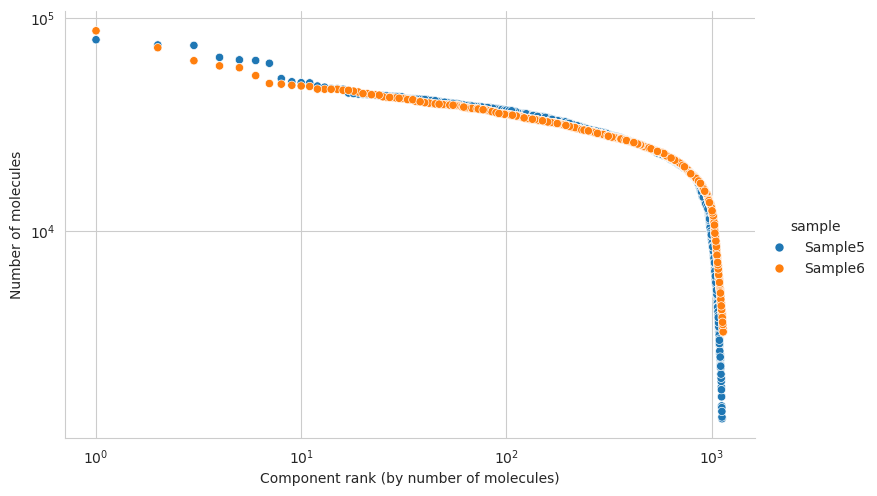

In [10]:
from pixelator.plot import molecule_rank_plot, cell_count_plot, scatter_umi_per_upia_vs_tau
pg_data_combined = pd_data.adata
molecule_rank_df = pg_data_combined.obs[["sample", "molecules"]].copy()
molecule_rank_df["rank"] = molecule_rank_df.groupby(["sample"])["molecules"].rank(
    ascending=False, method="first"
)
fig, ax = molecule_rank_plot(molecule_rank_df, group_by="sample")

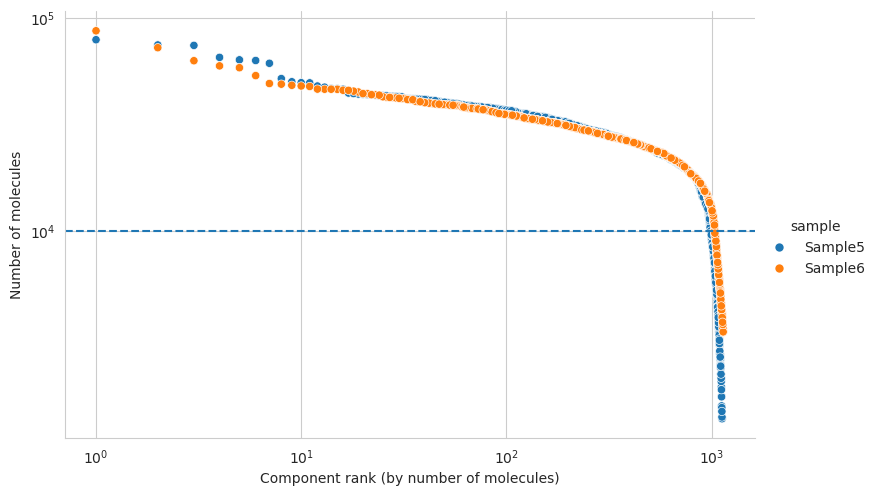

In [11]:
fig, ax = molecule_rank_plot(molecule_rank_df, group_by="sample")
ax.axhline(10000, linestyle="--")

# Filter cells to have at least 10000 edges
pg_data_combined = pg_data_combined[pg_data_combined.obs["molecules"] >= 10000]

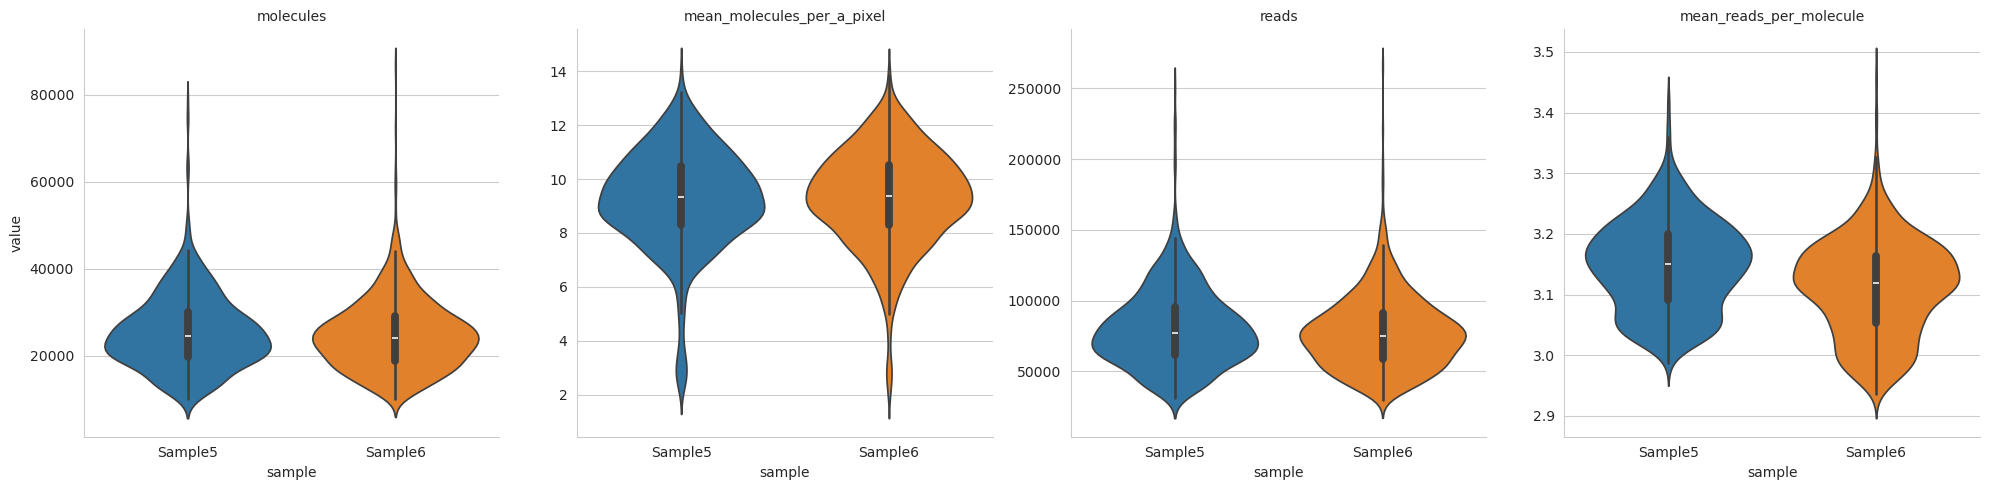

In [12]:
import seaborn as sns

metrics_per_sample_df = pg_data_combined.obs[
    ["sample", "molecules", "mean_molecules_per_a_pixel", "reads", "mean_reads_per_molecule"]
].melt(id_vars=["sample"])
metrics_plot = sns.catplot(
    data=metrics_per_sample_df,
    x="sample",
    col="variable",
    y="value",
    kind="violin",
    sharex=True,
    sharey=False,
    margin_titles=True,
    hue="sample",
).set_titles(col_template="{col_name}")

metrics_plot

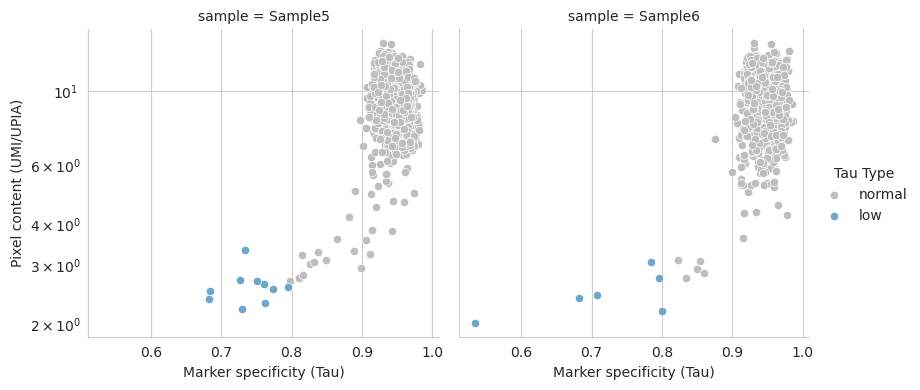

In [13]:
tau_metrics_df = pg_data_combined.obs[["sample", "tau", "mean_molecules_per_a_pixel", "tau_type"]]
tau_metrics_df = tau_metrics_df.rename(columns={"mean_molecules_per_a_pixel": "umi_per_upia"})


fig, ax = scatter_umi_per_upia_vs_tau(tau_metrics_df, group_by="sample")

In [14]:
components_to_keep = pd_data.adata[
    (pd_data.adata.obs["molecules"] >= 10000)
    & (pd_data.adata.obs["tau_type"] == "normal")
].obs.index

pd_data.filter(components=components_to_keep).save(f'{pixel_dir}/V2_combined_data_filtered.pxl', force_overwrite=True)

Overwriting existing .pxl file at /home/labs/amit/floriani/Lab/PROJECTS/Pixelgen/data/raw/PBMC_pilot_data//V2_combined_data_filtered.pxl
/home/labs/amit/floriani/mambaforge/envs/pixel_env/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing write_elem from `anndata.experimental` is deprecated. Import anndata.io.write_elem instead.
  warnings.warn(msg, FutureWarning)


In [15]:
from pixelator.plot import density_scatter_plot
from pixelator.analysis.normalization import dsb_normalize
import numpy as np

# Add dsb values as a layer to the object
pg_data_combined.layers["dsb"] = dsb_normalize(
    pg_data_combined.to_df(), 
    isotype_controls = ["mIgG1", "mIgG2a", "mIgG2b"]
    )
# Create log1p layer for later comparisons
pg_data_combined.layers['log1p'] = np.log1p(pg_data_combined.to_df())

/tmp/ipykernel_20384/318153099.py:6: ImplicitModificationWarning: Setting element `.layers['dsb']` of view, initializing view as actual.
  pg_data_combined.layers["dsb"] = dsb_normalize(


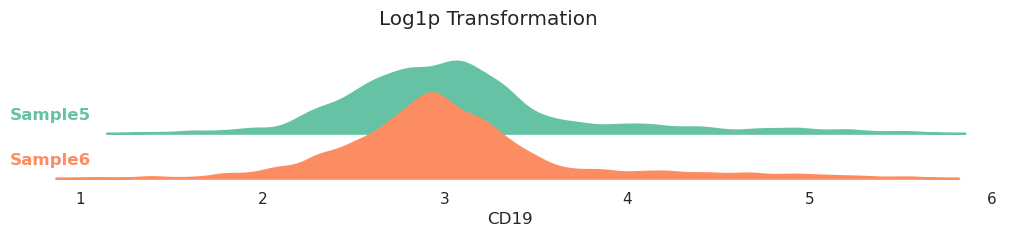

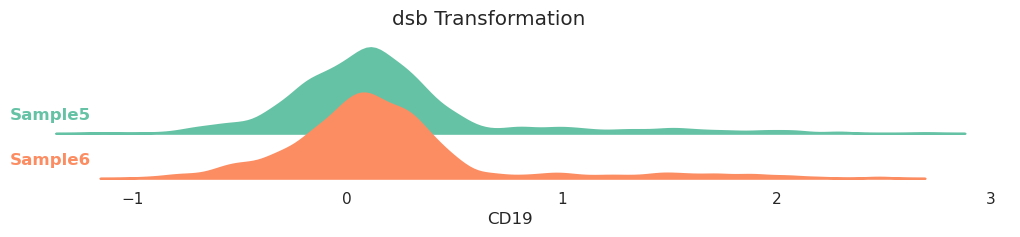

In [16]:
# log1p ridgeplot data
import matplotlib.pyplot as plt
import pandas as pd

layer_data_log = pg_data_combined.to_df("log1p")
data_log = layer_data_log.loc[:, "CD19"]
samples = pg_data_combined.obs.loc[:, 'sample']
plot_data_log = pd.DataFrame({'CD19' : data_log, 'Samples' : samples})
# Initialize the FacetGrid object
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), 'axes.linewidth':2})
pal = sns.color_palette("Set2", 12)
g = sns.FacetGrid(plot_data_log, row="Samples", hue="Samples", aspect=9, height=1.2, palette=pal)
# Draw the densities in a few steps
g.map(sns.kdeplot, "CD19", bw_adjust=.5, clip_on=False, fill=True, alpha=1, linewidth=1.5)
# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)
g.map(label, "CD19")
# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.5)
# Clean up plot
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)
g.fig.suptitle('Log1p Transformation')
# Dsb ridgeplot
layer_data_dsb = pg_data_combined.to_df("dsb")
data_dsb = layer_data_dsb.loc[:, "CD19"]
plot_data_dsb = pd.DataFrame({'CD19' : data_dsb, 'Samples' : samples})
# Initialize the FacetGrid object
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), 'axes.linewidth':2})
pal = sns.color_palette("Set2", 12)
g = sns.FacetGrid(plot_data_dsb, row="Samples", hue="Samples", aspect=9, height=1.2, palette=pal)
# Draw the densities in a few steps
g.map(sns.kdeplot, "CD19", bw_adjust=.5, clip_on=False, fill=True, alpha=1, linewidth=1.5)
# Add label
g.map(label, "CD19")
# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.5)
# Clean up plot
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)
g.fig.suptitle('dsb Transformation')

dsb_plot = g.fig.show()  

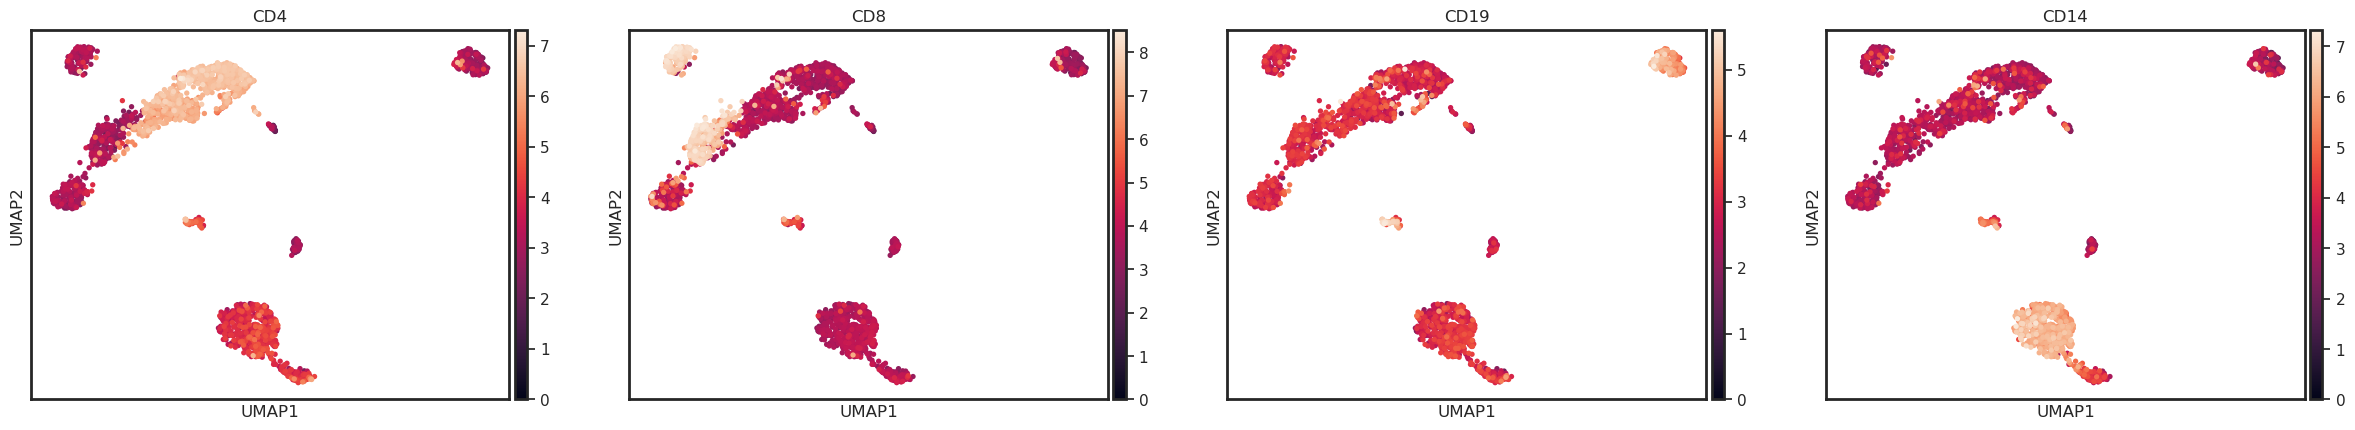

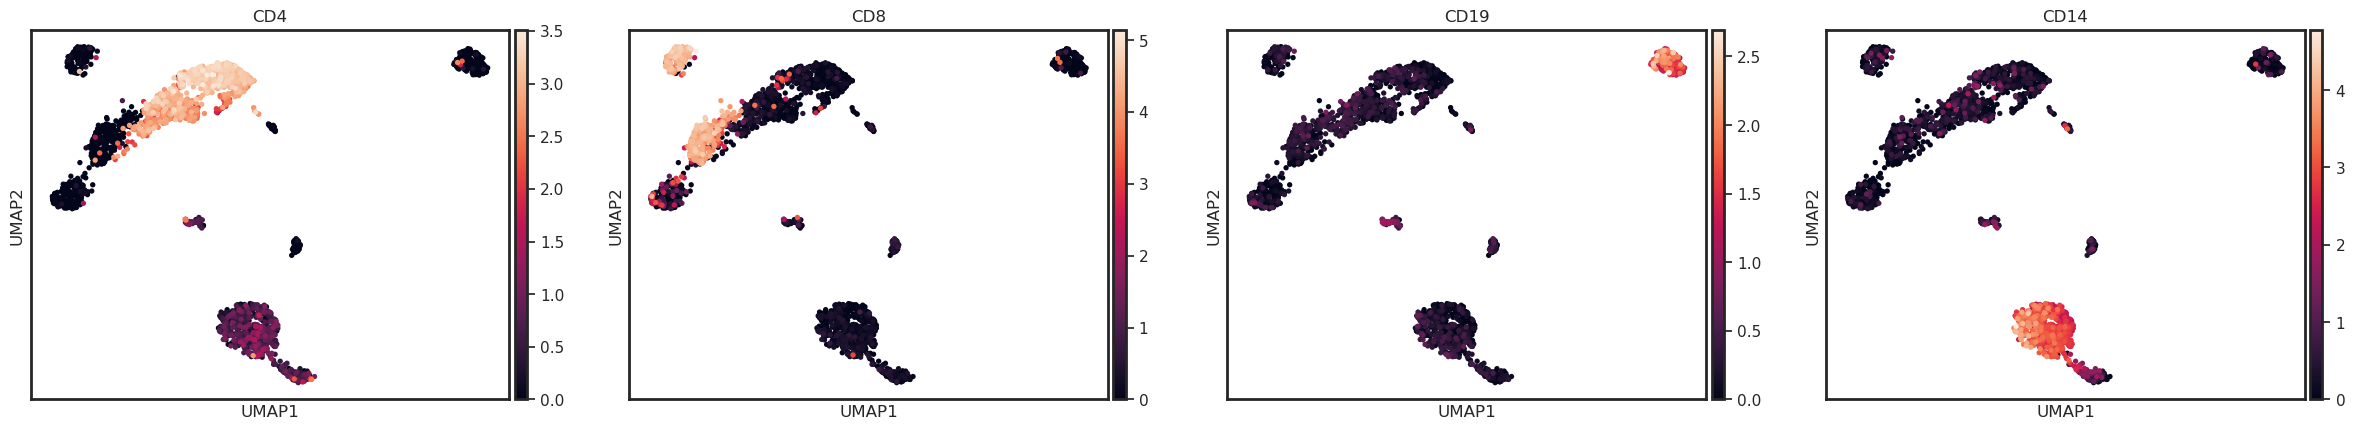

In [17]:
import scanpy as sc
pg_data_combined.layers['raw'] = pg_data_combined.X.copy()

sc.pp.highly_variable_genes(
    pg_data_combined, flavor="seurat_v3", n_top_genes=50
)
pg_data_combined.layers["scaled_dsb"] = sc.pp.scale(
    pg_data_combined, zero_center=True, layer="dsb", copy=True
).layers["dsb"]

pg_data_combined.obsm["pca"] = sc.tl.pca(
    pg_data_combined.layers["scaled_dsb"], random_state=42
)

sc.pp.neighbors(
    pg_data_combined,
    n_neighbors=30,
    n_pcs=10,
    use_rep="pca",
    metric="cosine",
)
sc.tl.umap(
    pg_data_combined,
    min_dist=0.3,
)
markers_of_interest = ["CD4", "CD8", "CD19", "CD14"]
sc.pl.umap(pg_data_combined, color=markers_of_interest, ncols=4, layer = "log1p", vmin=0)
sc.pl.umap(pg_data_combined, color=markers_of_interest, ncols=4, layer = "dsb", vmin=0)

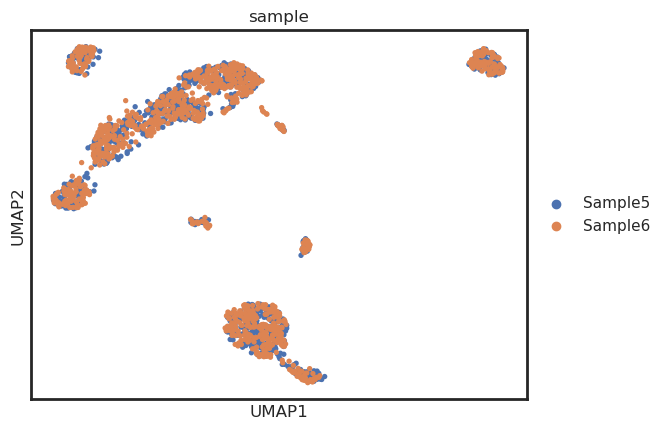

In [18]:
sc.pl.umap(pg_data_combined, color=['sample'], ncols=4, layer = "log1p", vmin=0)

In [19]:
pg_data_combined.write_h5ad(f'{pixel_dir}/V2_combined_data_filtered_normalized.h5ad')

In [62]:
pg_data_combined.obs

,pixels,a_pixels,b_pixels,antibodies,molecules,reads,mean_reads_per_molecule,median_reads_per_molecule,mean_b_pixels_per_a_pixel,median_b_pixels_per_a_pixel,mean_a_pixels_per_b_pixel,median_a_pixels_per_b_pixel,a_pixel_b_pixel_ratio,mean_molecules_per_a_pixel,median_molecules_per_a_pixel,leiden,tau_type,tau,sample
component,,,,,,,,,,,,,,,,,,,
RCVCMP0000000_Sample5,5833,3749,2084,79,35040,114108,3.256507,3.0,2.794345,2.0,5.026871,3.0,1.798944,9.346492,5.0,0,normal,0.935262,Sample5
RCVCMP0000001_Sample5,4769,3338,1431,79,33399,107689,3.224318,3.0,2.933493,2.0,6.842767,4.0,2.332635,10.005692,5.0,1,normal,0.939779,Sample5
RCVCMP0000002_Sample5,4227,2724,1503,78,34376,113349,3.297330,3.0,3.825624,3.0,6.933466,4.0,1.812375,12.619677,7.5,0,normal,0.922382,Sample5
RCVCMP0000004_Sample5,3285,2159,1126,79,13859,42368,3.057075,3.0,2.352478,2.0,4.510657,3.0,1.917407,6.419176,3.0,2,normal,0.938652,Sample5
RCVCMP0000005_Sample5,9958,6413,3545,79,43839,136302,3.109149,3.0,2.397318,2.0,4.336812,3.0,1.809027,6.835958,3.0,3,normal,0.945426,Sample5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RCVCMP0002879_Sample6,3336,2263,1073,77,16749,49580,2.960177,3.0,2.562086,2.0,5.403541,3.0,2.109040,7.401237,4.0,10,normal,0.972535,Sample6
RCVCMP0002911_Sample6,3117,2016,1101,76,18563,56205,3.027797,3.0,3.536210,2.0,6.475023,4.0,1.831063,9.207837,5.0,2,normal,0.930334,Sample6
RCVCMP0003087_Sample6,2011,1360,651,78,11791,37595,3.188449,3.0,2.444118,2.0,5.105991,3.0,2.089094,8.669853,4.0,15,normal,0.946096,Sample6


# read seurat v4 data and process in the same way

In [50]:
import anndata as ad
adata_cite_seq = ad.read_h5ad('/home/labs/amit/floriani/Lab/PROJECTS/FlowVI/data/raw/CITE_seq/Seurat_PBMC/2024-02-16_cite_seq_processed.h5ad')
adata_cite_seq = adata_cite_seq[adata_cite_seq.obs['orig.ident'].isin(['P7_0'])].copy()

In [56]:
# dsb normalize
ig_controls = ['Rat-IgG1-1', 'Rat-IgG2b',  'Rat-IgG1-2',  'Rag-IgG2c']

adata_cite_seq.layers["dsb"] = dsb_normalize(
    adata_cite_seq.to_df(), 
    isotype_controls = ig_controls
    )

In [58]:
adata_cite_seq.write_h5ad(f'{pixel_dir}/CITE_seq_seuratv4_dsb_normalized.h5ad')